<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

last update: 2021/08/22   
created: : 2021/07/20  

written with reference to :  
"exojax/examples/tutorial/Forward\ modeling.ipynb"  
"ghR/exojax_0/examples/testlines/line_strength_CO.py"  

In [2]:
cd ~/work

/Users/chonmac/work


In [31]:
%load_ext autoreload
%autoreload 2
#↑Reload the imported module each time running
from exojax.spec.rtransfer import nugrid
from exojax.spec.rtransfer import pressure_layer 
from exojax.spec import moldb, molinfo, contdb
from exojax.spec import vald3api, vald3
from exojax.spec.exomol import gamma_exomol
from exojax.spec import SijT, doppler_sigma, gamma_natural
from exojax.spec import planck
import jax.numpy as jnp
from jax import vmap, jit
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Set the path to save figures (optional)

In [5]:
#import pathlib
#path_fig = pathlib.Path('~/Dropbox/tmpfig')  #('/home/tako/work/fig')

## T-P profile 

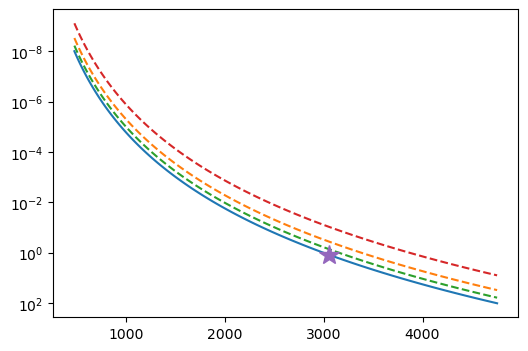

In [32]:
#Assume ATMOSPHERE                                                                     
NP=100
T0=3000. #10000. #3000. #1295.0 #K
Parr, dParr, k=pressure_layer(NP=NP)
Tarr = T0*(Parr)**0.1

#tako210815 (roughly based on "p3200_g+5.0_m0.0_t01_st_z+0.00_a+0.00_c+0.00_n+0.00_o+0.00_r+0.00_s+0.00.mod" of MARCS model atmosphere)  
PH = 0.3 * Parr #H I
PHH = 0.6 * Parr #H2
PHe = 0.078 * Parr #He

#%matplotlib notebook
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(6,4))
plt.plot(Tarr,Parr)
plt.plot(Tarr, PH, '--'); plt.plot(Tarr, PHH, '--'); plt.plot(Tarr, PHe, '--'); plt.plot(Tarr[80],Parr[80], marker='*', markersize=15)
plt.yscale("log")
plt.gca().invert_yaxis()
plt.show()

## Wavenumber

In [7]:
#We set a wavenumber grid using nugrid.

nus,wav,res = nugrid(10380, 10450, 1000, unit="AA") 
#nus,wav,res = nugrid(10380, 10750, 5000, unit="AA")
#nus,wav,res=nugrid(22920,23000,1000,unit="AA")

nugrid is log: mode= lpf


## Load a database of atomic lines from VALD3

In [9]:
#Loading a database of a few atomic lines from VALD3  #BU: CO and CIA (H2-H2)... 

adbTest=moldb.AdbVald('~/work/HiroyukiIshikawa.4203812_test0724.ip', nus, crit=1.e-100) #, crit=1.e-46)
#mdbCO=moldb.MdbExomol('.database/CO/12C-16O/Li2015',nus,crit=1.e-46)
#cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia',nus)

Reading VALD file


In [10]:
#check
print(adbTest.ielem)
print(adbTest.atomicmass) #mass of each species
print(1.e8/adbTest.nu_lines)

[22 26 26]
[47.89999 55.847   55.847  ]
[10399.6492 10398.6434 10381.8432]


## Relative partition function

In [11]:
#Computing the relative partition function,

qt_284=vmap(adbTest.QT_interp_284)(Tarr)
qt = np.zeros([len(adbTest.QTmask), len(Tarr)])
#qt = np.empty_like(adbTest.QTmask, dtype='object')
for i, mask in enumerate(adbTest.QTmask):
    qt[i] = qt_284[:,mask]  #e.g., qt_284[:,76] #Fe I
qt = jnp.array(qt)

print(qt.shape) #check

(3, 100)


## Pressure and Natural broadenings (Lorentzian width)  


In [12]:
#test to compare  
#fudge!

#Use ad hoc values based on "exojax/examples/tutorial/Forward modeling.ipynb"  #test#tako
Tar = 0.01 #0.0688
TnT = 0.01 #0.65

Test_alpha_ref = jnp.array(np.ones_like(adbTest._A) * Tar)
Test_n_Texp = jnp.array(np.ones_like(adbTest._A) * TnT)

gammaLMP_fudge = jit(vmap(gamma_exomol,(0,0,None,None)))\
        (Parr, Tarr, Test_n_Texp, Test_alpha_ref)  #tako #fudge

#check 
gammaLMP_fudge[80]

DeviceArray([0.01176708, 0.01176708, 0.01176708], dtype=float32)

In [13]:
gammaLMP = jit(vmap(vald3.gamma_vald3,(0,0,0,0,0,None,None,None,None,None,None)))\
        (Parr, Tarr, PH, PHH, PHe, \
                adbTest.dev_nu_lines, adbTest.elower, adbTest.ionE, \
                adbTest.gamRad, adbTest.vdWdamp, 1.4)  
gammaLMN = vald3.gamma_natural(adbTest.A)
gammaLM = gammaLMP + gammaLMN[None,:] 

print(gammaLMN.shape, gammaLMN[None,:].shape, gammaLM.shape) #check

(3,) (1, 3) (100, 3)


In [14]:
#check 
nlayer = 80
gammaLMP_fudge[nlayer],  gammaLMP[nlayer], gammaLMN[nlayer], gammaLM[nlayer]

(DeviceArray([0.01176708, 0.01176708, 0.01176708], dtype=float32),
 DeviceArray([0.79161835, 0.8100571 , 0.8100571 ], dtype=float32),
 DeviceArray(2.3366449e-09, dtype=float32),
 DeviceArray([0.7916187, 0.8100571, 0.8100571], dtype=float32))

## Doppler broadening

In [15]:
from exojax.spec import doppler_sigma
print(adbTest.nu_lines.shape, Tarr.shape, adbTest.atomicmass.shape)#check
sigmaDM=jit(vmap(doppler_sigma,(None,0,None)))\
    (adbTest.nu_lines, Tarr, adbTest.atomicmass)

(3,) (100,) (3,)


## Line strength

In [16]:
from exojax.spec import SijT
print(Tarr.shape, adbTest.logsij0.shape, adbTest.nu_lines.shape, adbTest.elower.shape, qt.T.shape) #check
SijM=jit(vmap(SijT,(0,None,None,None,0)))\
    (Tarr, adbTest.logsij0, adbTest.nu_lines, adbTest.elower, qt.T)

(100,) (3,) (3,) (3,) (100, 3)


In [17]:
#check
print(SijM.shape)
SijM[-5:,:] #five deepest atmospheric layers

(100, 3)


DeviceArray([[1.0283577e-17, 2.4879396e-19, 3.8808878e-20],
             [1.0591176e-17, 2.8283688e-19, 4.4273185e-20],
             [1.0892123e-17, 3.2047526e-19, 5.0337052e-20],
             [1.1185731e-17, 3.6194500e-19, 5.7043092e-20],
             [1.1471146e-17, 4.0748788e-19, 6.4434371e-20]],            dtype=float32)

## nu matrix

In [18]:
from exojax.spec import make_numatrix0
numatrix=make_numatrix0(nus, adbTest.nu_lines)

In [19]:
numatrix.shape

(3, 1000)

## Compute dtau for each atomic species (or ion) in a SEPARATE array

Separate species

In [20]:
def get_unique_list(seq):
    seen = []
    return [x for x in seq if x not in seen and not seen.append(x)]

uspecies = get_unique_list(jnp.vstack([adbTest.ielem, adbTest.iion]).T.tolist())

Set the stellar/planetary parameters

In [21]:
#Parameters of Objects
Rp = 0.36*10 #R_sun*10    #Rp=0.88 #[R_jup]
Mp = 0.37*1e3 #M_sun*1e3    #Mp=33.2 #[M_jup]
g = 2478.57730044555*Mp/Rp**2
print('logg: '+str(np.log10(g))) #check
#g=1.e5 #gravity cm/s2

logg: 4.849799190511717


Calculate delta tau

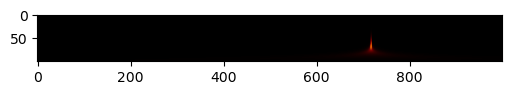

(100,) (100, 1000) (100,)
22 1 3.1272314e-06 47.89999


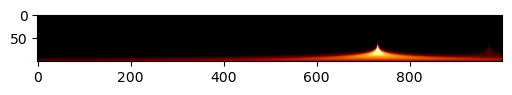

(100,) (100, 1000) (100,)
26 1 0.0012936727 55.847


In [33]:
#For now, ASSUME all atoms exist as neutral atoms. 
#In fact, we can't ignore the effect of molecular formation e.g. TiO (」゜□゜)」

from exojax.spec.lpf import xsmatrix
from exojax.spec.rtransfer import dtauM

ieleml = jnp.array(adbTest.ipccd['ielem'])
Narr = jnp.array(10**(12+adbTest.ipccd['solarA'])) #number density
massarr = jnp.array(adbTest.ipccd['mass']) #mass of each neutral atom
Nmassarr = Narr * massarr #mass of each neutral species

dtaual = np.zeros([len(uspecies), len(Tarr), len(nus)])
maskl = np.zeros(len(uspecies)).tolist()
for i, sp in enumerate(uspecies):
    maskl[i] = (adbTest.ielem==sp[0])\
                    *(adbTest.iion==sp[1])
    
    #Currently not dealing with ionized species yet... (#tako %\\\\20210814)
    if sp[1] > 1:
        continue
     
    #Providing numatrix, thermal broadening, gamma, and line strength, we can compute cross section.  
    xsm=xsmatrix(numatrix[maskl[i]], sigmaDM.T[maskl[i]].T, gammaLM.T[maskl[i]].T, SijM.T[maskl[i]].T)
        #xsmatrix has the shape of (# of layers, # of nu grid)
    ntmpf = 'tmp' + str(i) + '.pdf'
    fig=plt.figure(figsize=(6,1))
    plt.imshow(xsm, cmap="afmhot")#, aspect=5.)
    #plt.savefig(path_fig/ntmpf)
    plt.show() 
    
    #Computing delta tau for atomic absorption
    MMR_X_I = Nmassarr[ jnp.where(ieleml==sp[0])[0][0] ] / jnp.sum(Nmassarr)
    mass_X_I = massarr[ jnp.where(ieleml==sp[0])[0][0] ]
    #    ↑MMR and mass of neutral atom X (if all elemental species are neutral)
    dtaual[i] = dtauM(dParr, xsm, MMR_X_I*np.ones_like(Tarr), mass_X_I, g)

    #check
    print(dParr.shape, xsm.shape, (MMR_X_I*np.ones_like(Tarr)).shape)
    print(sp[0], sp[1], MMR_X_I, mass_X_I)

compute delta tau for CIA

In [23]:
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia', nus)

from exojax.spec.rtransfer import dtauCIA
mmw=2.33 #mean molecular weight
mmrH2=0.74
molmassH2=molinfo.molmass("H2")
vmrH2=(mmrH2*mmw/molmassH2) #VMR
dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,\
            mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)

H2-H2


## Total delta tau

In [24]:
dtau = np.sum(dtaual, axis=0) + dtaucH2H2

## Plot contribution function

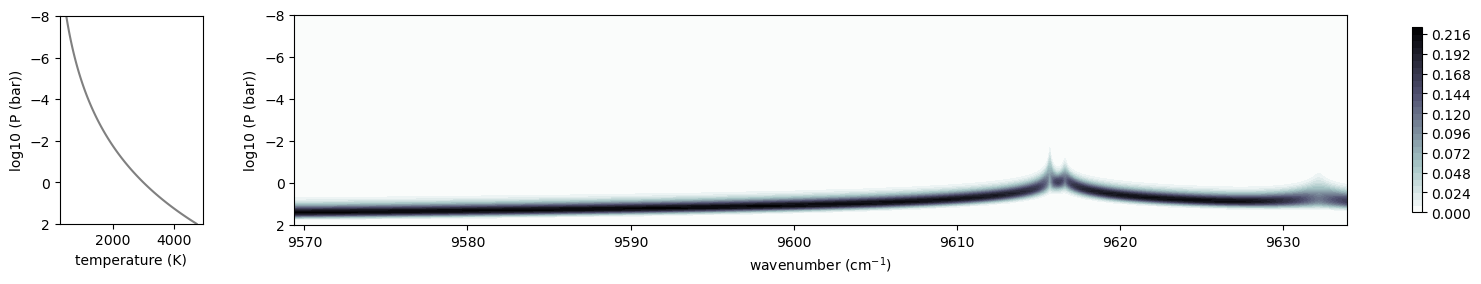

In [34]:
from exojax.plot.atmplot import plotcf
#fig=plt.figure(figsize=(3, 2))
plotcf(nus,dtau,Tarr,Parr,dParr)
plt.show()
#plt.savefig(path_fig/'contributionf_210814_test1.pdf') #tako

## Radiative transfer

In [35]:
from exojax.spec import planck
from exojax.spec.rtransfer import rtrun
sourcef = planck.piBarr(Tarr, nus)
F0=rtrun(dtau, sourcef)

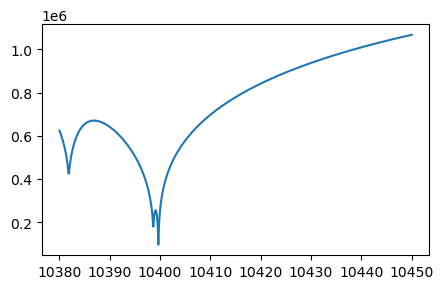

In [36]:
fig=plt.figure(figsize=(5, 3))
plt.plot(wav[::-1],F0)
plt.show()
#plt.savefig(path_fig/'flux_210814_test2.pdf') #tako

In [37]:
#Check line wavelength
print(adbTest.ielem)
print(1.e8/adbTest.nu_lines)

[22 26 26]
[10399.6492 10398.6434 10381.8432]


## Rotational & instrumental broadening

In [38]:
from exojax.spec import response
from exojax.utils.constants import c #[km/s]
import jax.numpy as jnp

wavd=jnp.linspace(10380, 10450,500) #observational wavelength grid
nusd = 1.e8/wavd[::-1]

RV=10.0 #RV km/s
vsini=20.0 #Vsini km/s
u1=0.0 #limb darkening u1
u2=0.0 #limb darkening u2

R=100000.
beta=c/(2.0*np.sqrt(2.0*np.log(2.0))*R) #IP sigma need check 

Frot=response.rigidrot(nus,F0,vsini,u1,u2)
F=response.ipgauss_sampling(nusd,nus,Frot,beta,RV)

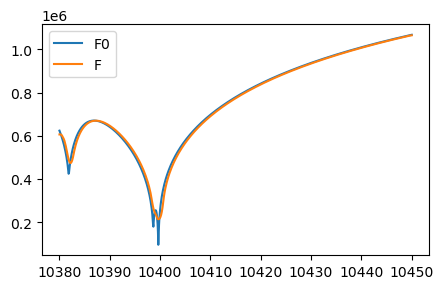

In [39]:
fig=plt.figure(figsize=(5, 3))
plt.plot(wav[::-1],F0, label='F0')
plt.plot(wavd[::-1],F, label='F')
plt.legend()
plt.show()
#plt.savefig(path_fig/'flux+rot_210814_test3_dtaual.pdf') #tako